Firstly, I have used pretrained convolutional based models (a custom CNN, VGG19, Inception, ResNet101 etc.), but haven't obtained a good F1 Score in the test prediction. Then I tried a pretrained ViT model with preprocessed images I obtained good results. 

<br>
In addition, training this type of datasets can give rise to overfit easily due to the data leakage problem [1,2]. Our model shouldn't see the test set's samples. In this dataset, the file name format is 'case_002...'. I split all the same case files into train, validation and test datasets by hand (DataFrame splitting). For example, in all case_009 files only are used in the train dataset. 


I have used the following methods.

* I used a mirrored strategy (using 2 T4 GPU at the same time),
* Used <b>tf.data</b> for input pipeline,
* I used two image processing methods for images <span style="color:#e74c3c;"> <b>(Green Channel Conversion[3] , Histogram Equalization[4])</b> </span>
* I used a pretrained <b>ViT (Vision Transformer)</b> architecture [5],
* <b>gelu</b> activation function during the classification stage,


## Image Processing Operation
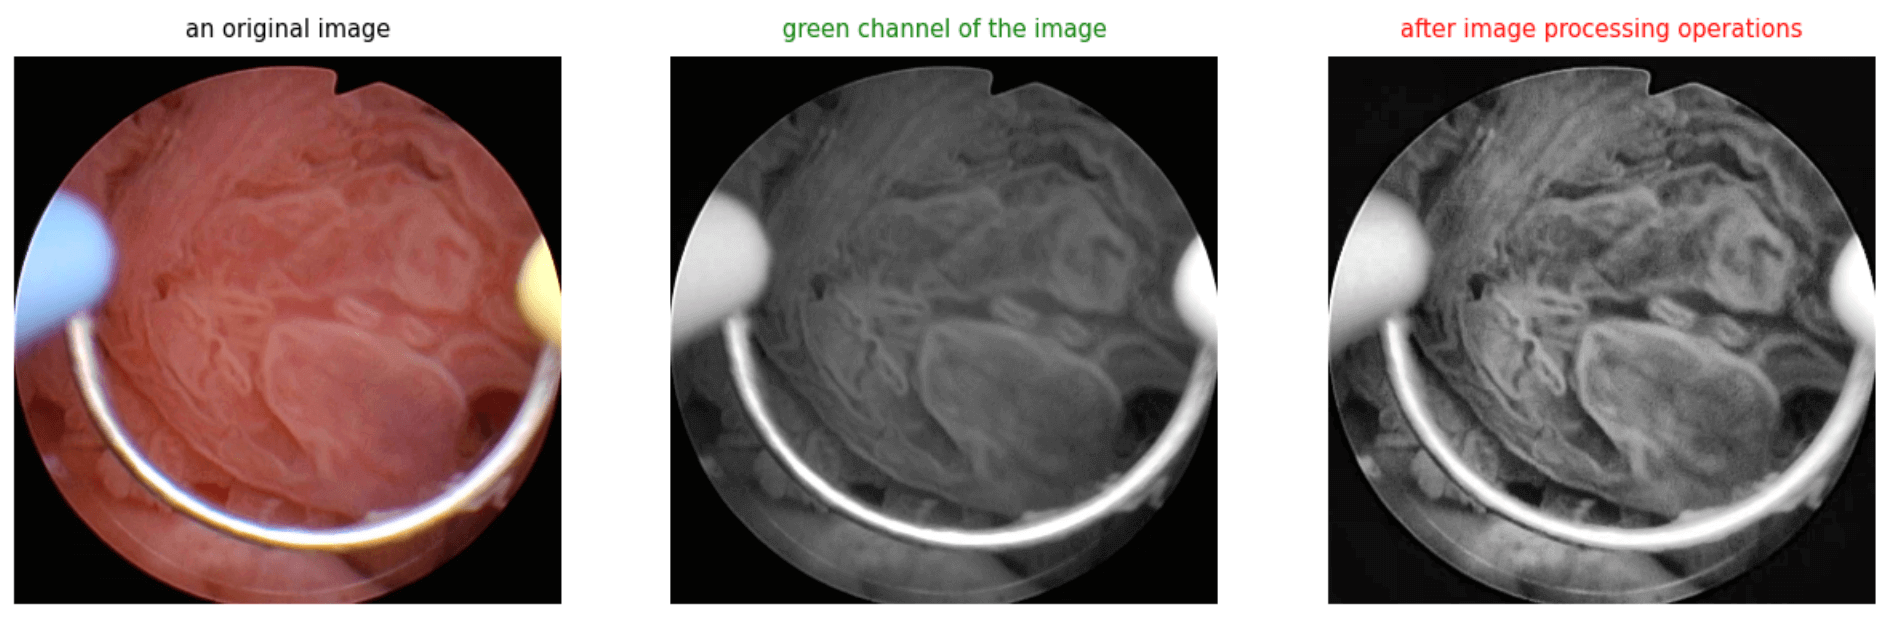

## Test Set Predictions
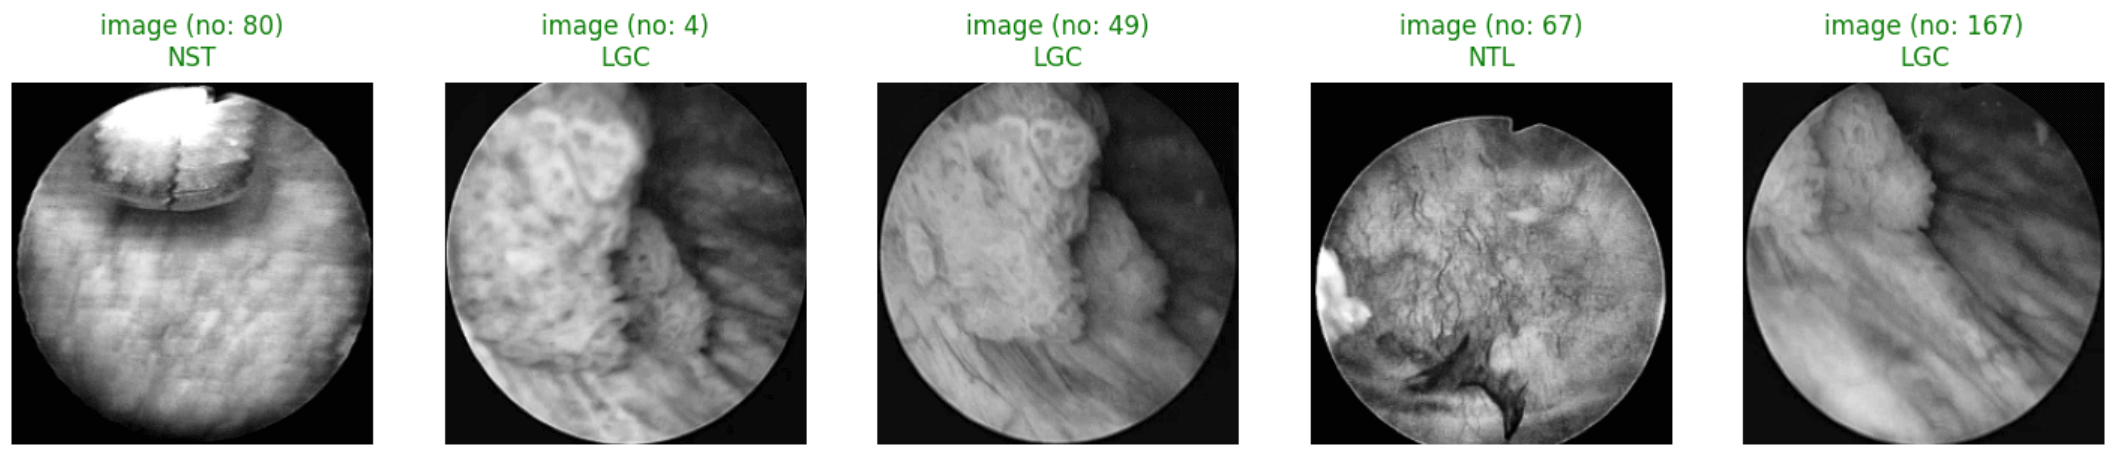


## My Another Projects
* [Leaf Disease Detection w/Meta-Learning (ViT, SVM)](https://www.kaggle.com/code/banddaniel/leaf-disease-detection-w-meta-learning-vit-svm)
* [Skin Cancer Detect w/Meta Learning (CNN, CatBoost)](https://www.kaggle.com/code/banddaniel/skin-cancer-detect-w-meta-learning-cnn-catboost)
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)


## References
1. https://en.wikipedia.org/wiki/Leakage_(machine_learning)
2. https://dataintegration.info/detect-multicollinearity-target-leakage-and-feature-correlation-with-amazon-sagemaker-data-wrangler
3. Rathod, Deepali & Manza, Ramesh & Rajput, Yogesh & Patwari, Manjiri & Saswade, Manoj & Deshpande, Neha. (2014). Localization of Optic Disc and Macula using Multilevel 2-D Wavelet Decomposition Based on Haar Wavelet Transform. International Journal of Engineering Research & Technology (IJERT)
4. https://en.wikipedia.org/wiki/Histogram_equalization
5. https://pypi.org/project/keras-vit/1.0.1/

In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from vit_keras import vit


SEED = 30
BATCH_SIZE = 32
IMG_SIZE = 224, 224
AUTO = tf.data.AUTOTUNE

In [3]:
# Creating a distributed deep learning strategy

stg = tf.distribute.MirroredStrategy()

# <span style="color:#e74c3c;"> Image </span> Preprocessing


Text(0.5, 1.0, 'after image processing operations')

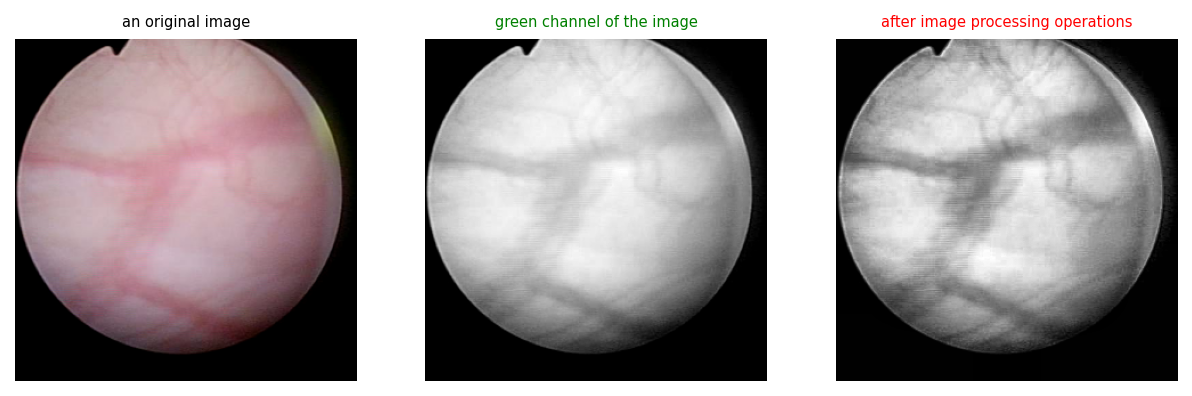

In [4]:
# Chosing a random image from the dataset
main_path = '/kaggle/input/endoscopic-bladder-tissue-classification-dataset/EndoscopicBladderTissue/NST'
original_train_images =  sorted(os.listdir(main_path))
org_img_path =  np.random.permutation(original_train_images)[0]
img = os.path.join(main_path,org_img_path)

# Reading and converting
normal_image = cv2.imread(img)
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB) 

# Splitting Green channel from a RGB image 
green_channnel = normal_image[:,::,1] 

# Applying CLAHE operation
clahe_op = cv2.createCLAHE(clipLimit= 2 , tileGridSize=(5,5))
defect_final_img = clahe_op.apply(green_channnel)



fig, ax = plt.subplots(1,3, figsize = (10,10), dpi = 150)

ax[0].imshow(normal_image)
ax[0].axis('off')
ax[0].set_title('an original image', fontsize = 7)

ax[1].imshow(green_channnel, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('green channel of the image', fontsize = 7, color = 'green')

ax[2].imshow(defect_final_img, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('after image processing operations', fontsize = 7, color = 'red')

In [5]:
# Creating new directories

os.mkdir(os.path.join('/kaggle/working/', 'HGC'))
os.mkdir(os.path.join('/kaggle/working/', 'NTL'))
os.mkdir(os.path.join('/kaggle/working/', 'LGC'))
os.mkdir(os.path.join('/kaggle/working/', 'NST'))

In [6]:
# Image processing function
def image_chale_gray(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :
        img = cv2.imread(os.path.join(main_path, i))[:,::,1]
        clahe_op = cv2.createCLAHE(clipLimit= 2, tileGridSize=(5,5))
        img = clahe_op.apply(img)
        cv2.imwrite(os.path.join(target_path, i), img)

        
# Applying the image processing function to all images
image_chale_gray('/kaggle/input/endoscopic-bladder-tissue-classification-dataset/EndoscopicBladderTissue/HGC', '/kaggle/working/HGC')
image_chale_gray('/kaggle/input/endoscopic-bladder-tissue-classification-dataset/EndoscopicBladderTissue/LGC', '/kaggle/working/LGC')
image_chale_gray('/kaggle/input/endoscopic-bladder-tissue-classification-dataset/EndoscopicBladderTissue/NST', '/kaggle/working/NST')
image_chale_gray('/kaggle/input/endoscopic-bladder-tissue-classification-dataset/EndoscopicBladderTissue/NTL', '/kaggle/working/NTL')

# <span style="color:#e74c3c;"> Creating </span> Train, Validation and Test Sets

In [7]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


# look-up table
classes = {0:'HGC', 1 : 'LGC', 2: 'NST', 3:'NTL'}


HGC_data = create_images_list('/kaggle/working/HGC')
LGC_data = create_images_list('/kaggle/working/LGC')
NST_data = create_images_list('/kaggle/working/NST')
NTL_data = create_images_list('/kaggle/working/NTL')



train_data_df = pd.concat([
    pd.DataFrame({ 'img': HGC_data[88:374], 'label': 0 }),
    pd.DataFrame({ 'img': LGC_data[:201], 'label': 1 }),
    pd.DataFrame({ 'img': LGC_data[234:603], 'label': 1 }),
    pd.DataFrame({ 'img': NST_data[9:485], 'label': 2 }),
    pd.DataFrame({ 'img': NTL_data[8:124], 'label': 3 })], ignore_index = True)


val_data_df = pd.concat([
    pd.DataFrame({ 'img': HGC_data[:88], 'label': 0 }),
    pd.DataFrame({ 'img': LGC_data[201:234], 'label': 1 }),
    pd.DataFrame({ 'img': NST_data[:9], 'label': 2 }),
    pd.DataFrame({ 'img': NTL_data[:8], 'label': 3 })], ignore_index = True)


test_data_df = pd.concat([
    pd.DataFrame({ 'img': HGC_data[374:], 'label': 0 }),
    pd.DataFrame({ 'img': LGC_data[603:], 'label': 1 }),
    pd.DataFrame({ 'img': NST_data[485:], 'label': 2 }),
    pd.DataFrame({ 'img': NTL_data[124:], 'label': 3 })], ignore_index = True)


train_data_df = shuffle(train_data_df).reset_index(drop = True)
val_data_df = shuffle(val_data_df).reset_index(drop = True)
test_data_df = shuffle(test_data_df).reset_index(drop = True)


print("train images: ", train_data_df.shape[0])
print("validation images: ", val_data_df.shape[0])
print("test images: ", test_data_df.shape[0])

train images:  1448
validation images:  138
test images:  168


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [8]:
# Reading and resizing images
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

# Data augmentation
def img_augmentation(image, label):    
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 4, seed = SEED)
    
    return img, label

In [9]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data_df['img'], train_data_df['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(img_augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 15)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


val_loader = tf.data.Dataset.from_tensor_slices((val_data_df['img'], val_data_df['label']))
val_dataset = (val_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(img_augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 15)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data_df['img'], test_data_df['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# <span style="color:#e74c3c;"> ViT (Vision Transformer) </span> Model


In [10]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 4)
    
    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(128, activation = 'gelu')(X)
    X = Dense(32, activation = 'gelu')(X)
    out = Dense(4, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top_2_acc", dtype=None) ] )

347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                            

# <span style="color:#e74c3c;"> Training</span> 

In [11]:
hist = model.fit(train_dataset, epochs = 10, batch_size = BATCH_SIZE, validation_data = val_dataset)

Epoch 1/10
46/46 [==============================] - 137s 935ms/step - loss: 0.7039 - acc: 0.7293 - top_2_acc: 0.8833 - val_loss: 1.3069 - val_acc: 0.5145 - val_top_2_acc: 0.8043
Epoch 2/10
46/46 [==============================] - 39s 840ms/step - loss: 0.2525 - acc: 0.9081 - top_2_acc: 0.9841 - val_loss: 2.8440 - val_acc: 0.3261 - val_top_2_acc: 0.5435
Epoch 3/10
46/46 [==============================] - 38s 813ms/step - loss: 0.1699 - acc: 0.9420 - top_2_acc: 0.9910 - val_loss: 2.8148 - val_acc: 0.3986 - val_top_2_acc: 0.6304
Epoch 4/10
46/46 [==============================] - 39s 827ms/step - loss: 0.0723 - acc: 0.9744 - top_2_acc: 0.9959 - val_loss: 3.4605 - val_acc: 0.4348 - val_top_2_acc: 0.5145
Epoch 5/10
46/46 [==============================] - 38s 822ms/step - loss: 0.0331 - acc: 0.9862 - top_2_acc: 1.0000 - val_loss: 3.0536 - val_acc: 0.4783 - val_top_2_acc: 0.6304
Epoch 6/10
46/46 [==============================] - 38s 821ms/step - loss: 0.0439 - acc: 0.9855 - top_2_acc: 0.999

# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation

In [12]:
test_eval = model.evaluate(test_dataset)
print('Test Accuracy: {0:.2f} %'.format(test_eval[1] * 100))

6/6 [==============================] - 2s 204ms/step - loss: 0.5486 - acc: 0.7976 - top_2_acc: 0.9464
Test Accuracy: 79.76 %


In [13]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred = np.argmax(pred, axis = 1)

6/6 [==============================] - 7s 198ms/step


# <span style="color:#e74c3c;"> Classification </span> Report

In [14]:
# Classification Report

clf = classification_report(test_data_df['label'] , pred, target_names = list(classes.values()) )
print(clf)

              precision    recall  f1-score   support

         HGC       0.95      0.74      0.83        95
         LGC       0.88      0.82      0.85        44
         NST       0.95      0.95      0.95        19
         NTL       0.29      1.00      0.45        10

    accuracy                           0.80       168
   macro avg       0.77      0.88      0.77       168
weighted avg       0.89      0.80      0.82       168



# <span style="color:#e74c3c;"> Confusion </span> Matrix

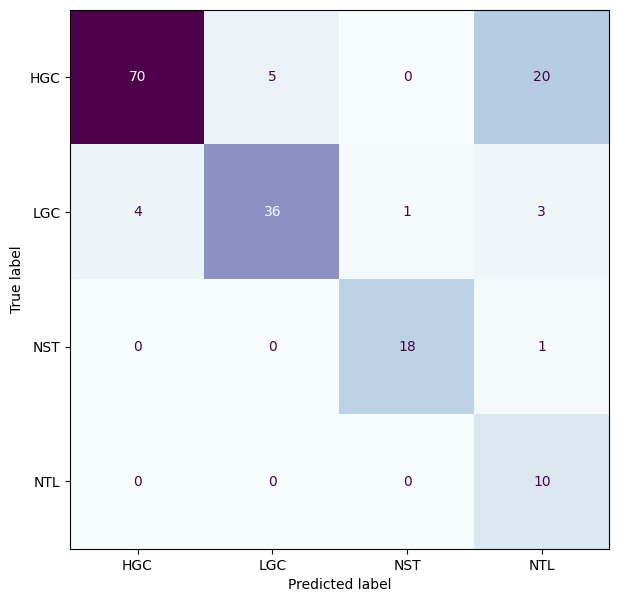

In [15]:
cm = confusion_matrix(test_data_df['label'] ,pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [16]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

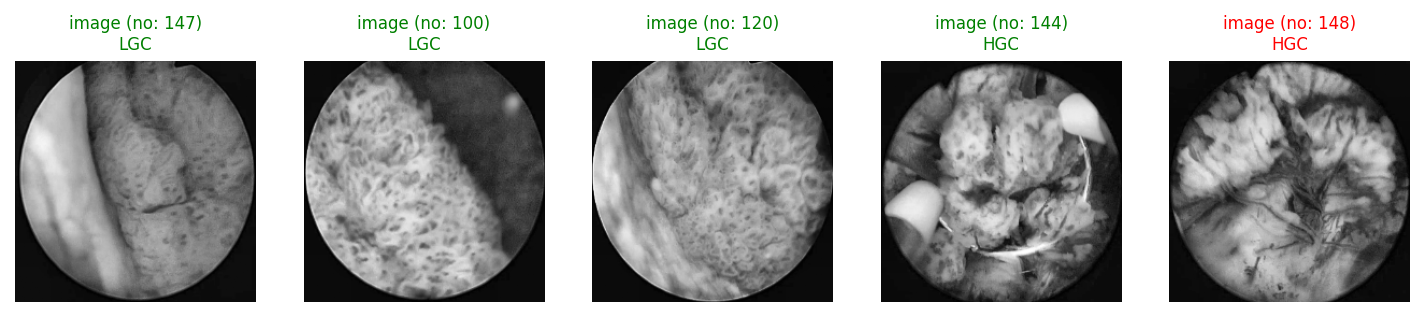

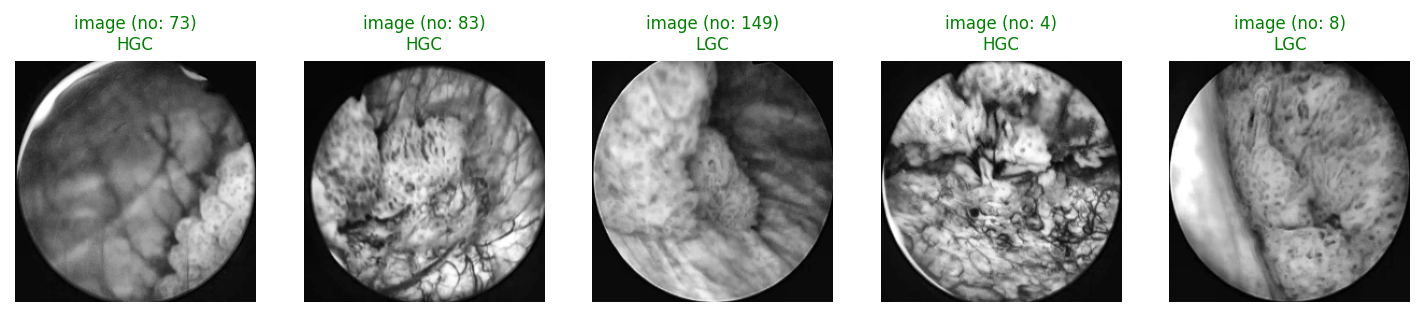

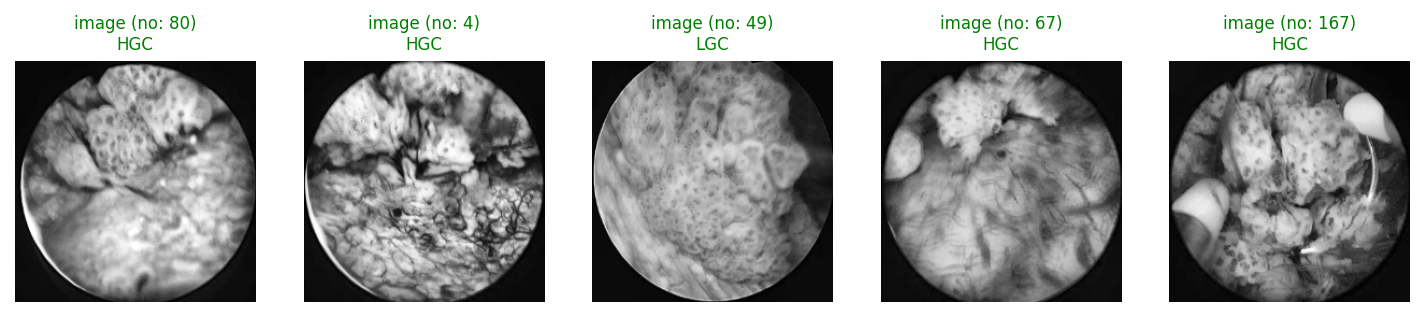

In [17]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 13)
random_test_sample_with_prediction(SEED = 52)
random_test_sample_with_prediction(SEED = 153)